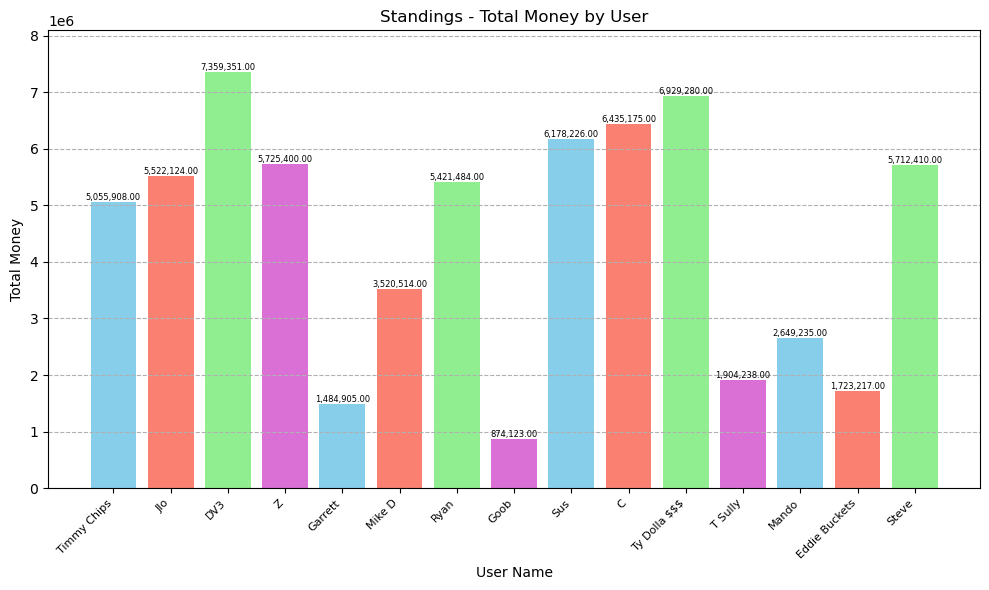

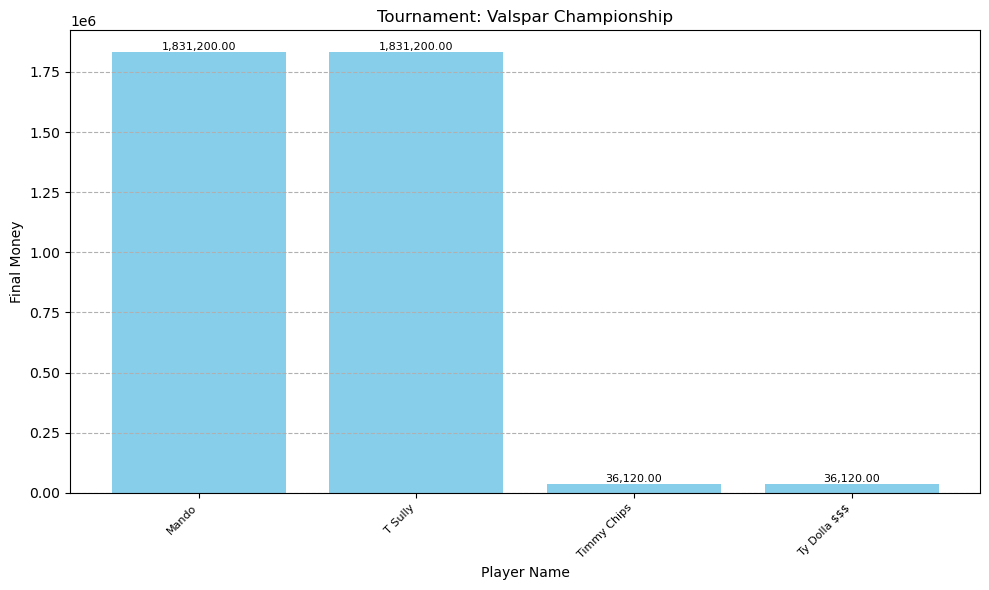

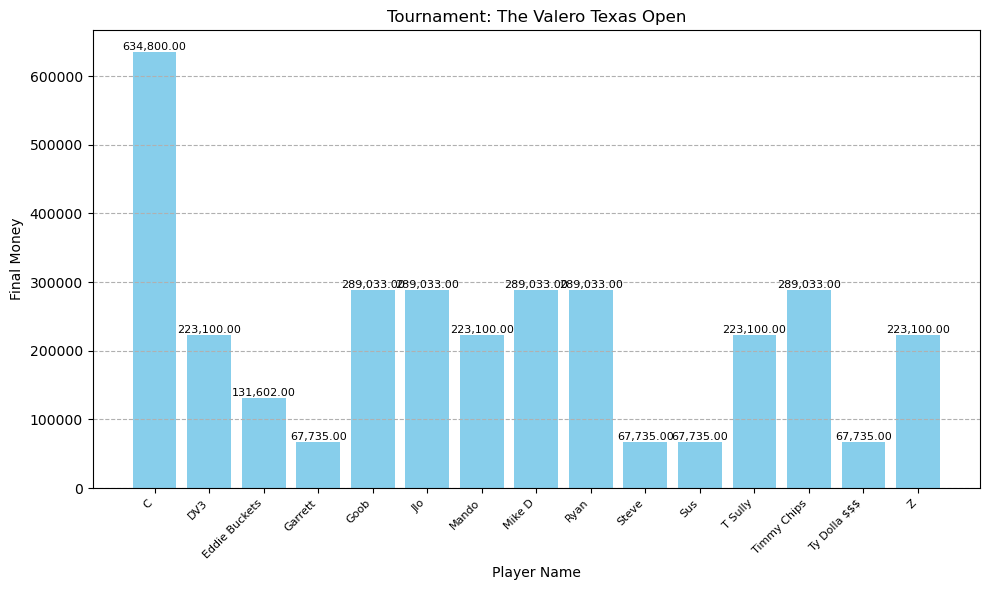

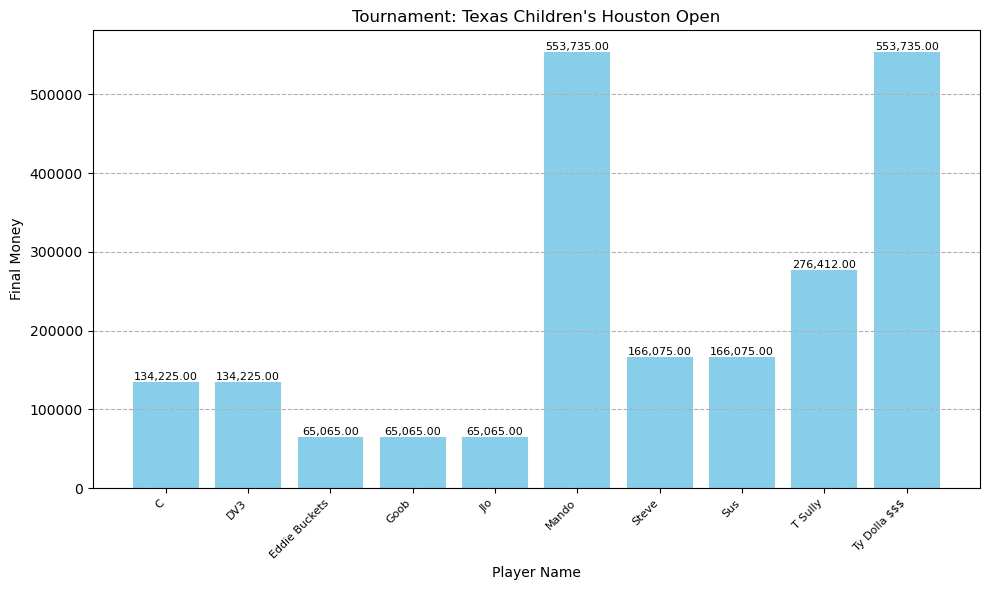

In [15]:
import tkinter as tk
from tkinter import ttk
import psycopg2
import pandas as pd
import sqlite3 
from tkinter import messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt

# read various files and creds, need to make these all into postgres queries
db_creds = pd.read_csv('/users/zack burnside/desktop/database_creds.csv')
tournament_data = pd.read_csv('/users/zack burnside/desktop/tournament_info.csv')
player_choice = pd.read_csv('/users/zack burnside/desktop/player_db.csv')
usernames = names = [
    "Z",
    "Timmy Chips",
    "Goob",
    "C",
    "Steve",
    "Sus",
    "DV3",
    "Jlo",
    "Ty Dolla $$$",
    "Ryan",
    "Mike D",
    "Mando",
    "Eddie Buckets",
    "Garrett",
    "T Sully"
]

tournament_names = list(tournament_data['tournament_name'])
player_picks = list(player_choice['player_name'])
original_tournament_names = tournament_names.copy()
original_usernames = usernames.copy()
original_player_picks = player_picks.copy()

# submit button
def submit():
    user_name = user_name_var.get()
    tournament_name = tournament_name_var.get()
    player_pick = player_pick_var.get()
    date = None
    
    # connect to postgres DB
    conn = psycopg2.connect(
        dbname = db_creds['dbname'][0],
        user = db_creds['user'][0],
        password = db_creds['password'][0],
        host = db_creds['host'][0],
        port = "5433"
    )
    c = conn.cursor()
    
    # Check if the player has been previously picked by the user
    c.execute('''SELECT player_pick FROM user_picks WHERE user_name = %s''', (user_name,))
    previous_picks = c.fetchall()
    previous_picks = [pick[0] for pick in previous_picks]

    
    if player_pick in previous_picks:
        messagebox.showinfo("Error", "You have already picked this player. Please choose a different player.")
        conn.close()
        return
    
    c.execute('''SELECT tournament_name FROM user_picks WHERE user_name = %s''', (user_name,))
    tournament_picks = c.fetchall()
    tournament_picks = [pick[0] for pick in tournament_picks]

    if tournament_name in tournament_picks:
        messagebox.showinfo("Error", "That Tournament already happened. Please choose a different tournament.")
        conn.close()
        return

    
    # insert data into postgres db
    c.execute('''INSERT INTO public.user_picks (tournament_name, user_name, date, player_pick)
             VALUES (%s, %s, %s, %s)''', (tournament_name, user_name, date, player_pick))
    
    print({'Username' : user_name,
           'Tournament Name' : tournament_name,
           'Player Pick' : player_pick
           })
    
    conn.commit()
    conn.close()

#show standings button
def show_standings():
    # Connect to PostgreSQL database
    conn = psycopg2.connect(
        dbname = db_creds['dbname'][0],
        user = db_creds['user'][0],
        password = db_creds['password'][0],
        host = db_creds['host'][0],
        port = "5433"
    )
    cursor = conn.cursor()

    # Execute a SELECT query to retrieve all rows from the 'picks' table
    cursor.execute("SELECT * FROM public.active_standings_table")

    rows = cursor.fetchall()
    conn.close()

    return rows
def display_standings():

    # Retrieve standings data
    standings_data = show_standings()

    if standings_data:  # Check if data is retrieved successfully
        # Create a new window for standings
        standings_window = tk.Toplevel(root)
        standings_window.title("Standings")
        
        frame = tk.Frame(standings_window)
        frame.pack(padx=10, pady=10)

        # Create a Treeview widget
        tree = ttk.Treeview(standings_window, columns=("User Name", "Total Money"), show="headings")
        tree.heading("User Name", text="User Name")
        tree.heading("Total Money", text="Total Money")
        tree.pack()

        # Insert data into the Treeview
        for row in standings_data:
            formatted_row = (row[0], '{:,.0f}'.format(round(row[1])))  # Round and format the money value
            tree.insert("", "end", values=formatted_row)
        
        usernames = [row[0] for row in standings_data]
        total_money = [row[1] for row in standings_data]

        plt.figure(figsize=(10, 6))
        bars = plt.bar(usernames, total_money, color=['skyblue', 'salmon', 'lightgreen', 'orchid'])

        # Add labels on top of the bars
        for bar in bars:
            money_value = bar.get_height()
            formatted_money = '{:,.2f}'.format(round(money_value)) # Format money value with commas and two decimal places
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                    formatted_money, ha='center', va='bottom', fontsize=6)

        # Add title and axis labels
        plt.title('Standings - Total Money by User', fontsize = 12)
        plt.xlabel('User Name', fontsize = 10)
        plt.ylabel('Total Money', fontsize = 10)
        plt.grid(axis='y', linestyle='--')
        plt.ylim(0, max(total_money) * 1.1)
        plt.xticks(rotation=45, ha='right', fontsize = 8)
        plt.tight_layout()

        canvas = FigureCanvasTkAgg(plt.gcf(), frame)
        canvas.draw()
        canvas.get_tk_widget().pack(side="right", padx=10)

    else:
        # Display an error message if no data is retrieved
        error_message = "Error: Unable to retrieve standings data."
        tk.messagebox.showerror("Error", error_message)

#drop down menu filtering
def filter_dropdown(event):
    # Get the current text in the combobox
    current_text = event.widget.get().lower()
    # Determine which dropdown is being filtered
    if event.widget == tournament_name_dropdown:
        full_values = original_tournament_names
    elif event.widget == player_pick_dropdown:
        full_values = original_player_picks
    else:
        full_values = original_usernames  # Assuming this is the user names dropdown
    
    # Filter values based on current text
    filtered_values = [value for value in full_values if current_text in value.lower()]
    
    # If there are no filtered values, restore original values
    if not filtered_values:
        event.widget['values'] = full_values
    else:
        # Update combobox values with filtered values
        event.widget['values'] = filtered_values

#tournament info button
def tournament_info():# create a bar chart for the selected tournament

    conn = psycopg2.connect(
        dbname=db_creds['dbname'][0],
        user=db_creds['user'][0],
        password=db_creds['password'][0],
        host=db_creds['host'][0],
        port="5433"
    )

    info_window = tk.Toplevel()
    info_window.title("Tournament Info")
    
    table_frame = ttk.Frame(info_window)
    table_frame.pack(pady=10)

    # Retrieve player picks from the database
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM public.tournament_info")
    data = cursor.fetchall()

    # Create table headers
    tree = ttk.Treeview(table_frame, columns=("Tournament Number","Tournament Name", "Dates", "Purse"), show="headings")
    tree.heading("Tournament Number", text="Tournament Number")
    tree.heading("Tournament Name", text="Tournament Name")
    tree.heading("Dates", text="Dates")
    tree.heading("Purse", text="Purse")
    tree.pack()

    # Insert data into the Treeview
    for row in data:
        tree.insert("", "end", values=row)
    
    conn.close()

    info_window.mainloop()
#past result functions
def get_unique_tournament_names():
    conn = psycopg2.connect(
        dbname=db_creds['dbname'][0],
        user=db_creds['user'][0],
        password=db_creds['password'][0],
        host=db_creds['host'][0],
        port="5433"
    )
    cursor = conn.cursor()
    cursor.execute("SELECT DISTINCT(tournament_name) FROM public.weekly_results")
    tournament_names = [row[0] for row in cursor.fetchall()]
    conn.close()
    return tournament_names
def show_tournament_chart(tournament_name):# create a bar chart for the selected tournament

    conn = psycopg2.connect(
        dbname=db_creds['dbname'][0],
        user=db_creds['user'][0],
        password=db_creds['password'][0],
        host=db_creds['host'][0],
        port="5433"
    )
    cursor = conn.cursor()
    cursor.execute("SELECT user_name, total_money FROM public.weekly_results WHERE tournament_name = %s", (tournament_name,))
    data = cursor.fetchall()

    players = [row[0] for row in data]
    final_money = [row[1] for row in data]

    # create a window to show the chart and create the chart
    chart_window = tk.Toplevel()
    chart_window.title(f"Tournament: {tournament_name}")
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(players, final_money, color='skyblue')

    # Add labels on top of the bars
    for bar in bars:
        money_value = bar.get_height()
        formatted_money = '{:,.2f}'.format(round(money_value)) 
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), formatted_money,
                ha='center', va='bottom', fontsize=8)

    # Labels and Axis set up
    ax.set_title(f"Tournament: {tournament_name}", fontsize=12)
    ax.set_xlabel('Player Name', fontsize=10)
    ax.set_ylabel('Final Money', fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.grid(axis='y', linestyle='--') # Add grid lines
    plt.tight_layout()

    canvas = FigureCanvasTkAgg(fig, master=chart_window)
    canvas.draw()
    canvas.get_tk_widget().pack()

    table_frame = ttk.Frame(chart_window)
    table_frame.pack(pady=10)

    # Retrieve player picks from the database
    cursor.execute("SELECT user_name, player_pick FROM public.user_picks WHERE tournament_name = %s", (tournament_name,))
    player_picks = cursor.fetchall()

    # Create table headers
    tree = ttk.Treeview(table_frame, columns=("User Name", "Player Pick"), show="headings")
    tree.heading("User Name", text="User Name")
    tree.heading("Player Pick", text="Player Pick")
    tree.pack()

    # Insert data into the Treeview
    for row in player_picks:
        tree.insert("", "end", values=row)
    
    conn.close()

    chart_window.mainloop()

def create_buttons(root, tournament_names): # create a button for each tournament

    for i, tournament_name in enumerate(tournament_names):
        button = tk.Button(root, text=tournament_name, command=lambda name=tournament_name: show_tournament_chart(name), bg="red", fg="white")
        button.grid(row=3 + i, column=5, pady=5)

#main window
root = tk.Tk()
root.title("PGA Pool Picker")

#theme
style = ttk.Style()
style.theme_use('clam')  

# style of the page
style.configure('TButton', font=('Arial', 12), foreground='black')
style.configure('TLabel', font=('Arial', 14), foreground='black') 

root.geometry('1200x1000') 
root.configure(padx=100, pady=100) 

# Create labels
user_name_label = ttk.Label(root, text="User Name:")
user_name_label.grid(row=0, column=0, padx=5, pady=5)

tournament_name_label = ttk.Label(root, text="Tournament Name:")
tournament_name_label.grid(row=1, column=0, padx=5, pady=5)

player_pick_label = ttk.Label(root, text="Player Pick:")
player_pick_label.grid(row=2, column=0, padx=5, pady=5)

# dropdown menus
user_name_var = tk.StringVar()
user_name_dropdown = ttk.Combobox(root, textvariable=user_name_var)
user_name_dropdown['values'] = usernames
user_name_dropdown.grid(row=0, column=1, padx=5, pady=5)
user_name_dropdown.bind("<KeyRelease>", filter_dropdown)

tournament_name_var = tk.StringVar()
tournament_name_dropdown = ttk.Combobox(root, textvariable=tournament_name_var)
tournament_name_dropdown['values'] = list(tournament_data['tournament_name'])
tournament_name_dropdown.grid(row=1, column=1, padx=5, pady=5)
tournament_name_dropdown.bind("<KeyRelease>", filter_dropdown)

player_pick_var = tk.StringVar()
player_pick_dropdown = ttk.Combobox(root, textvariable=player_pick_var)
player_pick_dropdown['values'] = list(player_choice['player_name'])
player_pick_dropdown.grid(row=2, column=1, padx=5, pady=5)
player_pick_dropdown.bind("<KeyRelease>", filter_dropdown)

# submit buton
submit_button = tk.Button(root, text="Submit", command=submit, bg="blue", fg="white")
submit_button.grid(row=3, column=0, columnspan=2, padx=5, pady=5)

# standings button
show_standings_button = tk.Button(root, text="Show Standings", command=display_standings, bg="green", fg="white")
show_standings_button.grid(row=0, column=5, pady=10)
# tournament info button
tournament_info_button = tk.Button(root, text="Tournament Info", command=tournament_info, bg="green", fg="white")
tournament_info_button.grid(row=1, column=5, pady=10)
# past results button
past_results_button = tk.Button(root, text='Past Results', command=lambda: create_buttons(root, get_unique_tournament_names()), bg="green", fg="white")
past_results_button.grid(row=2, column=5, pady=10)

root.mainloop()


In [16]:

tournament_names

['WM Phoenix Open',
 'The Genesis Invitational',
 'Mexico Open at Vidanta',
 'Cognizant Classic in The Palm Beaches',
 'Arnold Palmer Invitational presented by Mastercard',
 'THE PLAYERS Championship',
 'Valspar Championship',
 "Texas Children's Houston Open",
 'The Valero Texas Open',
 'Masters Tournament',
 'RBC Heritage',
 'Corales Puntacana Championship',
 'THE CJ CUP Byron Nelson',
 'Myrtle Beach Classic',
 'Wells Fargo Championship',
 'PGA Championship',
 'Charles Schwab Challenge',
 'RBC Canadian Open',
 'the Memorial Tournament presented by Workday',
 'U.S. Open',
 'Travelers Championship',
 'Rocket Mortgage Classic',
 'John Deere Classic',
 'Genesis Scottish Open',
 'Barracuda Championship',
 'The Open Championship',
 '3M Open',
 'Wyndham Championship',
 'FedEx St. Jude Championship',
 'BMW Championship',
 'TOUR Championship']